<a href="https://colab.research.google.com/github/srinathnaik/SpeechApp/blob/master/VMG_DeSnowNet_test5_half_ep17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
%load_ext tensorboard

In [3]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Necessary packages
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
import random
import warnings
import time
import copy
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import sys
import argparse
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms.functional as TF

#Gathering DataSet

In [5]:
# Constants
folder = "/content"

In [ ]:
# Download Train Datset
# !wget "https://desnownet.s3.amazonaws.com/dataset_synthetic/train/Snow100K-training.tar.gz" -O "/content/drive/My Drive/VMG/Snow100K-training.tar.gz"

In [ ]:
# Download Test Datset
# !wget "https://desnownet.s3.amazonaws.com/dataset_synthetic/test/Snow100K-testset.tar.gz" -O "/content/drive/My Drive/VMG/Snow100K-testset.tar.gz"

--2022-04-06 21:49:18--  https://desnownet.s3.amazonaws.com/dataset_synthetic/test/Snow100K-testset.tar.gz
Resolving desnownet.s3.amazonaws.com (desnownet.s3.amazonaws.com)... 52.219.124.88
Connecting to desnownet.s3.amazonaws.com (desnownet.s3.amazonaws.com)|52.219.124.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8344035776 (7.8G) [application/gzip]
Saving to: ‘/content/drive/My Drive/VMG/Snow100K-testset.tar.gz’

/content/drive/My D 100%[===================>]   7.77G  13.7MB/s    in 9m 40s  

2022-04-06 21:58:59 (13.7 MB/s) - ‘/content/drive/My Drive/VMG/Snow100K-testset.tar.gz’ saved [8344035776/8344035776]



In [ ]:
# Extract train data
# importing the "tarfile" module
# import tarfile
# file = tarfile.open("/content/drive/My Drive/VMG/Snow100K-training.tar.gz")
# file.extractall("/content/Snow100K-training3")
# file.close()

In [7]:
# Extract train data from zip file
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Copy of all.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Snow100K-training-small")

In [8]:
# !ls '/content/drive/My Drive/VMG/Snow100K-training/all/'
imgs = os.listdir('/content/Snow100K-training-small/all/synthetic')
# imgs = os.listdir('/content/Snow100K-training-small/all/gt')
# imgs = os.listdir('/content/Snow100K-training-small/all/mask')
print(len(imgs))

20000


In [9]:
# Dataset
class Snow100KDataset(Dataset):
  def __init__(self, root_dir):
    self.root_dir               = root_dir
    self.original_image_folder  = self.root_dir+"/all/gt/"
    self.mask_folder            = self.root_dir+"/all/mask/"
    self.synthetic_image_folder = self.root_dir+"/all/synthetic/"
    self.image_names            = os.listdir(self.original_image_folder)

  def __len__(self):
    return len(self.image_names)

  def transform(self, origImg, maskImg, snowImg):
    # Transform to tensor
    origImg = TF.to_tensor(origImg)
    maskImg = TF.to_tensor(maskImg)
    snowImg = TF.to_tensor(snowImg)

    # Random crop
    i, j, h, w = transforms.RandomCrop.get_params(origImg, output_size=(64, 64))
    origImg = TF.crop(origImg, i, j, h, w)
    maskImg = TF.crop(maskImg, i, j, h, w)
    snowImg = TF.crop(snowImg, i, j, h, w)
    return origImg, maskImg, snowImg

  def __getitem__(self, idx):
    image_name = self.image_names[idx]
    originalImagePath = os.path.join(self.original_image_folder, image_name)
    maskPath          = os.path.join(self.mask_folder, image_name)
    snowImagePath     = os.path.join(self.synthetic_image_folder, image_name)

    # Read image files
    originalImage = io.imread(originalImagePath)
    maskImage     = io.imread(maskPath)
    snowImage     = io.imread(snowImagePath)

    # Apply transform
    originalImage, maskImage, snowImage = self.transform(originalImage, maskImage, snowImage)
    sample = {'snow_image': snowImage, 'snow_free_image': originalImage, 'z':maskImage}

    return sample


In [10]:
# Train Dataset
train_dataset = Snow100KDataset(
                                  root_dir=folder+'/Snow100K-training-small',
                              )

In [11]:
# Train Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

#Visaualising dataset

In [12]:
# Visualise a batch
def visualise_batch(dataloader):
  dataiter = iter(dataloader)
  sample = dataiter.next()
  snowImgs = sample['snow_image']
  maskImgs = sample['z']
  origImgs = sample['snow_free_image']

  plt.figure()
  grid = utils.make_grid(snowImgs)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  plt.figure()
  grid = utils.make_grid(maskImgs)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  plt.figure()
  grid = utils.make_grid(origImgs)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()

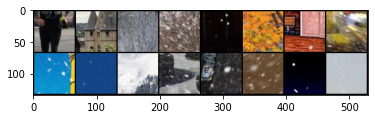

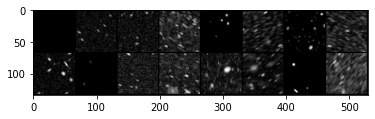

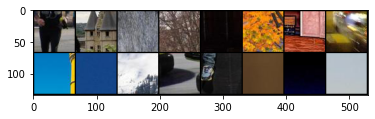

In [13]:
visualise_batch(train_dataloader)

# Model

In [11]:
# Factor by which whole model channels are reduced
factor=2

In [14]:
# Inception Module
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/inception_v4.py

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_planes, eps=0.001)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed3a(nn.Module):
    def __init__(self):
        super(Mixed3a, self).__init__()
        # self.maxpool = nn.MaxPool2d(3, stride=2)
        self.maxpool = nn.MaxPool2d(3, stride=1, padding=1)
        # self.conv = BasicConv2d(64, 96, kernel_size=3, stride=2)
        self.conv = BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.maxpool(x)
        x1 = self.conv(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed4a(nn.Module):
    def __init__(self):
        super(Mixed4a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(80//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(80//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 32//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(32//factor, 32//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(32//factor, 48//factor, kernel_size=(3, 3), stride=1, padding=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed5a(nn.Module):
    def __init__(self):
        super(Mixed5a, self).__init__()
        self.conv = BasicConv2d(96//factor, 96//factor, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.conv(x)
        x1 = self.maxpool(x)
        out = torch.cat((x0, x1), 1)
        return out


class InceptionA(nn.Module):
    def __init__(self):
        super(InceptionA, self).__init__()
        self.branch0 = BasicConv2d(192//factor, 48//factor, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48//factor, 48//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192//factor, 48//factor, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class ReductionA(nn.Module):
    def __init__(self):
        super(ReductionA, self).__init__()
        self.branch0 = BasicConv2d(192//factor, 192//factor, kernel_size=3, stride=1, padding=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 112//factor, kernel_size=3, stride=1, padding=1),
            BasicConv2d(112//factor, 128//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.MaxPool2d(3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class InceptionB(nn.Module):
    def __init__(self):
        super(InceptionB, self).__init__()
        self.branch0 = BasicConv2d(512//factor, 192//factor, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(512//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 112//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(112//factor, 128//factor, kernel_size=(7, 1), stride=1, padding=(3, 0))
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(512//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 96//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(96//factor, 112//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(112//factor, 112//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(112//factor, 128//factor, kernel_size=(1, 7), stride=1, padding=(0, 3))
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(512//factor, 64//factor, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class ReductionB(nn.Module):
    def __init__(self):
        super(ReductionB, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(512//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 96//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(512//factor, 128//factor, kernel_size=1, stride=1),
            BasicConv2d(128//factor, 128//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(128//factor, 160//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(160//factor, 160//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.MaxPool2d(3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class InceptionC(nn.Module):
    def __init__(self):
        super(InceptionC, self).__init__()

        self.branch0 = BasicConv2d(768//factor, 128//factor, kernel_size=1, stride=1)

        self.branch1_0 = BasicConv2d(768//factor, 192//factor, kernel_size=1, stride=1)
        self.branch1_1a = BasicConv2d(192//factor, 128//factor, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch1_1b = BasicConv2d(192//factor, 128//factor, kernel_size=(3, 1), stride=1, padding=(1, 0))

        self.branch2_0 = BasicConv2d(768//factor, 192//factor, kernel_size=1, stride=1)
        self.branch2_1 = BasicConv2d(192//factor, 224//factor, kernel_size=(3, 1), stride=1, padding=(1, 0))
        self.branch2_2 = BasicConv2d(224//factor, 256//factor, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch2_3a = BasicConv2d(256//factor, 128//factor, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch2_3b = BasicConv2d(256//factor, 128//factor, kernel_size=(3, 1), stride=1, padding=(1, 0))

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(768//factor, 128//factor, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)

        x1_0 = self.branch1_0(x)
        x1_1a = self.branch1_1a(x1_0)
        x1_1b = self.branch1_1b(x1_0)
        x1 = torch.cat((x1_1a, x1_1b), 1)

        x2_0 = self.branch2_0(x)
        x2_1 = self.branch2_1(x2_0)
        x2_2 = self.branch2_2(x2_1)
        x2_3a = self.branch2_3a(x2_2)
        x2_3b = self.branch2_3b(x2_2)
        x2 = torch.cat((x2_3a, x2_3b), 1)

        x3 = self.branch3(x)

        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionV4(nn.Module):
    def __init__(self, in_chans=3, output_stride=32, drop_rate=0.):
        super(InceptionV4, self).__init__()
        self.drop_rate = drop_rate

        self.features = nn.Sequential(
            BasicConv2d(in_chans, 16, kernel_size=3, stride=1, padding=1),
            BasicConv2d(16, 16, kernel_size=3, stride=1, padding=1),
            BasicConv2d(16, 32//factor, kernel_size=3, stride=1, padding=1),
            Mixed3a(),
            Mixed4a(),
            Mixed5a(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            ReductionA(),  # Mixed6a
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            ReductionB(),  # Mixed7a
            InceptionC(),
            InceptionC(),
            InceptionC(),
        )

    def forward_features(self, x):
        return self.features(x)

    def forward_head(self, x):
        if self.drop_rate > 0:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x

In [15]:
# Dilation Pyramid
class DilationPyramid(nn.Module):
  def __init__(self, gamma=4):
    super(DilationPyramid, self).__init__()
    self.dilatedConv0 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=1, padding=1)
    self.dilatedConv1 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=2, padding=2)
    self.dilatedConv2 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=4, padding=4)
    self.dilatedConv3 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=8, padding=8)
    self.dilatedConv4 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=16, padding=16)
  
  def forward(self, x):
    out0 = self.dilatedConv0(x)
    out1 = self.dilatedConv1(x)
    out2 = self.dilatedConv2(x)
    out3 = self.dilatedConv3(x)
    out4 = self.dilatedConv4(x)
    out  = torch.cat((out0, out1, out2, out3, out4), 1)
    return out


In [16]:
# Descriptor_T
class DescriptorT(nn.Module):
  def __init__(self):
    super(DescriptorT, self).__init__()
    self.iv4 = InceptionV4()
    self.dp  = DilationPyramid() 

  def forward(self, x):
    out_iv4 = self.iv4(x)
    out     = self.dp(out_iv4)
    return out


In [17]:
# Pyramid Maxout
class PyramidMaxout(nn.Module):
  def __init__(self, beta=4, out_dim=None):
    super(PyramidMaxout, self).__init__()
    self.conv1 = nn.Conv2d(1920//factor, out_dim, kernel_size=1)
    self.conv3 = nn.Conv2d(1920//factor, out_dim, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(1920//factor, out_dim, kernel_size=5, padding=2)
    self.conv7 = nn.Conv2d(1920//factor, out_dim, kernel_size=7, padding=3)

  def forward(self, x):
    out1 = self.conv1(x)
    out3 = self.conv3(x)
    out5 = self.conv5(x)
    out7 = self.conv7(x)

    out_a  = torch.maximum(out1, out3)
    out_b  = torch.maximum(out5, out7)
    out    = torch.maximum(out_a, out_b)
    return out

# Pyramid Sum
class PyramidSum(nn.Module):
  def __init__(self, beta=4, out_dim=None):
    super(PyramidSum, self).__init__()
    self.conv1 = nn.Conv2d(1920//factor, out_dim, kernel_size=1)
    self.conv3 = nn.Conv2d(1920//factor, out_dim, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(1920//factor, out_dim, kernel_size=5, padding=2)
    self.conv7 = nn.Conv2d(1920//factor, out_dim, kernel_size=7, padding=3)

  def forward(self, x):
    out1 = self.conv1(x)
    out3 = self.conv3(x)
    out5 = self.conv5(x)
    out7 = self.conv7(x)

    out_a  = torch.add(out1, out3)
    out_b  = torch.add(out5, out7)
    out    = torch.add(out_a, out_b)
    return out


In [18]:
# Snow Extractor
class SnowExtractor(nn.Module):
  def __init__(self):
    super(SnowExtractor, self).__init__()
    self.pyramidMaxout = PyramidMaxout(beta=4, out_dim=1)
    self.prelu = nn.PReLU()

  def forward(self, x):
    out = self.pyramidMaxout(x)
    out = self.prelu(out)
    return out

# Aberration Extractor
class AberrationExtractor(nn.Module):
  def __init__(self):
    super(AberrationExtractor, self).__init__()
    self.pyramidMaxout = PyramidMaxout(beta=4, out_dim=3)
    self.prelu = nn.PReLU()

  def forward(self, x):
    out = self.pyramidMaxout(x)
    out = self.prelu(out)
    return out


In [19]:
# Descriptor_R
class DescriptorR(nn.Module):
  def __init__(self):
    super(DescriptorR, self).__init__()
    self.iv4 = InceptionV4(in_chans=7)
    self.dp  = DilationPyramid()

  def forward(self, x):
    out1 = self.iv4(x)
    out  = self.dp(out1)
    return out


In [20]:
# RecoveryR
class RecoveryR(nn.Module):
  def __init__(self):
    super(RecoveryR, self).__init__()
    self.pyramidSum = PyramidSum(out_dim=3)

  def forward(self, x):
    out = self.pyramidSum(x)
    return out

In [21]:
# DeSnow Net
class DeSnowNet(nn.Module):
  def __init__(self):
    super(DeSnowNet, self).__init__()
    self.descriptorT    = DescriptorT()
    self.snowExtractor  = SnowExtractor()
    self.aberrationExtractor = AberrationExtractor()

    self.descriptorR    = DescriptorR()
    self.recoveryR      = RecoveryR()

  def forward(self, x):
    f_t     = self.descriptorT(x)
    z_hat   = self.snowExtractor(f_t)
    a       = self.aberrationExtractor(f_t)
    y_dash  = self.recover(x, z_hat, a)
    f_c     = torch.cat((y_dash, z_hat, a), 1)

    f_r     = self.descriptorR(f_c)
    r       = self.recoveryR(f_r)

    y_hat   = torch.add(y_dash, r)

    return y_hat, y_dash, z_hat
    
  def recover(self, x, z_hat, a):
    mask = z_hat<1.0
    out = (x-(a*z_hat))/(1-z_hat)
    out = out*mask+x*(~mask)
    return out


In [22]:
# Loss function
class DeSnowNetLoss(nn.Module):
  def __init__(self, lambda_z, t):
    super(DeSnowNetLoss, self).__init__()
    self.lambda_z = lambda_z
    self.t = t

  def forward(self, y_original, z_original, y_dash, y_hat, z_hat):
    L_y_dash  = self.pyramidLoss(y_original, y_dash, self.t)
    L_y_hat   = self.pyramidLoss(y_original, y_hat, self.t)
    L_z_hat   = self.pyramidLoss(z_original, z_hat, self.t)
    L_overall = L_y_dash + L_y_hat + (self.lambda_z * L_z_hat)
    return L_overall

  # Pyramid Loss
  def pyramidLoss(self, m, m_hat, t):
    loss = None
    for i in range(t):
      k = pow(2,i)
      poolM     = nn.MaxPool2d(kernel_size=(k,k), stride=(k,k))
      poolM_hat = nn.MaxPool2d(kernel_size=(k,k), stride=(k,k))
      t1 = poolM(m)
      t2 = poolM_hat(m_hat)
      diff = torch.sub(t1, t2)
      sqdiff = torch.square(diff)
      sumsqdiff = torch.sum(sqdiff)
      if i==0:
        loss = sumsqdiff
      else:
        loss += sumsqdiff
    return loss


In [23]:
# Training
def train(model, dataloader, criterion, optimizer, epochs, device, writer, modelStatePath):
  since = time.time()
  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    model.train() 

    running_loss = 0.0
    batch_loss_100 = 0.0
    i=0
    running_corrects = 0

    N = 0
    for i_batch, sample_batch in enumerate(dataloader):
      snow_images_batch, snow_free_images_batch, z_batch = sample_batch['snow_image'], sample_batch['snow_free_image'], sample_batch['z']
      snow_images_batch = snow_images_batch.to(device)
      snow_free_images_batch = snow_free_images_batch.to(device)
      z_batch = z_batch.to(device)

      optimizer.zero_grad()

      y_hat, y_dash, z_hat = model(snow_images_batch)
      loss = criterion(snow_free_images_batch, z_batch, y_dash, y_hat, z_hat)
      # loss.requires_grad= True
      loss.backward()
      optimizer.step()

      N += sample_batch['snow_image'].shape[0]

      running_loss += loss.item()
      batch_loss_100 += loss.item()

      i += 1
      if i%100==1:
        print(loss)
        writer.add_scalar('batch_loss_100', batch_loss_100, epoch*(len(dataloader)//100)+(i//100))
        batch_loss_100 = 0.0
        # save model
        torch.save(model.state_dict(), modelStatePath)

      # Back to cpu
      # snow_images_batch = snow_images_batch.to("cpu")
      # snow_free_images_batch = snow_free_images_batch.to("cpu")
      # z_batch = z_batch.to("cpu")

    epoch_loss = running_loss/N
    print('Train Loss: {:.10f}'.format(epoch_loss))
    writer.add_scalar('train epoch loss', epoch_loss, epoch)

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return model


In [ ]:
torch.cuda.empty_cache()

In [24]:
# Run Training
experimentName = "test5_half"
modelStatePath = "/content/drive/My Drive/VMG/"+experimentName
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter('runs/'+experimentName)
print("Using device ", device)

learning_rate = 3e-5
lambda_w = 5e-4
lambdaZ = 3
lossT = 4
epochs=60


Using device  cuda:0


In [25]:
# For a new model
model = DeSnowNet()
model = model.to(device)

In [ ]:
# Load model parameters from a state path
# modelStatePath = "/content/drive/My Drive/VMG/"+experimentName
# model.load_state_dict(torch.load(modelStatePath))

<All keys matched successfully>

In [26]:
criterion = DeSnowNetLoss(lambda_z=lambdaZ, t=lossT)  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_w)

In [ ]:
trained_test5 = train(model, train_dataloader, criterion, optimizer, epochs, device, writer, modelStatePath)

Epoch 0/59
----------
tensor(31413762., device='cuda:0', grad_fn=<AddBackward0>)
tensor(80847.3203, device='cuda:0', grad_fn=<AddBackward0>)
tensor(87018.0703, device='cuda:0', grad_fn=<AddBackward0>)
tensor(65359.8633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(67641.2344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(75003.4062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72646.6719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(56964.0625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(201750.0469, device='cuda:0', grad_fn=<AddBackward0>)
tensor(131624.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(109871.6562, device='cuda:0', grad_fn=<AddBackward0>)
tensor(201916.6406, device='cuda:0', grad_fn=<AddBackward0>)
tensor(150049.9844, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 9397.6616771484
Epoch 1/59
----------
tensor(151939.8906, device='cuda:0', grad_fn=<AddBackward0>)
tensor(106710.7812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(75031.8438, dev

In [28]:
trained_test4 = train(model, train_dataloader, criterion, optimizer, epochs, device, writer, modelStatePath)

Epoch 0/2
----------
tensor(18595.6367, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10920.5781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17873.5918, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24396.2422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30549.5703, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27295.1914, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13434.0352, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17228.7207, device='cuda:0', grad_fn=<AddBackward0>)
tensor(16483.2578, device='cuda:0', grad_fn=<AddBackward0>)
tensor(23862.5293, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14714.3623, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14126.5781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27120.2344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(12853.7598, device='cuda:0', grad_fn=<AddBackward0>)
tensor(19600.4824, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10541.5996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18504.6055, 

In [ ]:
trained_test3 = train(model, train_dataloader, criterion, optimizer, epochs, device, writer, modelStatePath)

Epoch 0/2
----------
tensor(264929.2188, device='cuda:0', grad_fn=<AddBackward0>)
tensor(109287.0234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72706.5312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(66988.5234, device='cuda:0', grad_fn=<AddBackward0>)
tensor(77387.0781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(62673.6719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(61504.7930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(77210.6484, device='cuda:0', grad_fn=<AddBackward0>)
tensor(83791.0859, device='cuda:0', grad_fn=<AddBackward0>)
tensor(82233.2109, device='cuda:0', grad_fn=<AddBackward0>)
tensor(76760.8125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(67382.0938, device='cuda:0', grad_fn=<AddBackward0>)
tensor(70415.1562, device='cuda:0', grad_fn=<AddBackward0>)
Train Loss: 16024.4289707031
Epoch 1/2
----------
tensor(73170.4453, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58198.7031, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58337.1719, device='

DeSnowNet(
  (descriptorT): DescriptorT(
    (iv4): InceptionV4(
      (features): Sequential(
        (0): BasicConv2d(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (2): BasicConv2d(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (3): Mixed3a(
          (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=

In [1]:
%tensorboard --logdir runs/

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# Define Training Parameters
model = DeSnowNet()
# summary(net, input_size=(3,64,64))


#Inference : Single Image

In [ ]:
model = DeSnowNet()
model = model.to(device)

In [29]:
# Load the saved model
experimentName="test4"
modelStatePath = "/content/drive/My Drive/VMG/"+experimentName
model.load_state_dict(torch.load(modelStatePath))

<All keys matched successfully>

In [30]:
# Constants
imName = "beautiful_smile_00006.jpg"
imageSnowName = "/content/Snow100K-training-small/all/synthetic/"+imName
imageOrigName = "/content/Snow100K-training-small/all/gt/"+imName
imageMaskName = "/content/Snow100K-training-small/all/mask/"+imName
imSnow = io.imread(imageSnowName)
imOrig = io.imread(imageOrigName)
imMask = io.imread(imageMaskName)

In [37]:
# To Tensor
tensorImgSnow = TF.to_tensor(imSnow)
tensorImgOrig = TF.to_tensor(imOrig)
tensorImgMask = TF.to_tensor(imMask)

# Random crop
i, j, h, w = transforms.RandomCrop.get_params(tensorImgSnow, output_size=(64, 64))
croppedImgSnow = TF.crop(tensorImgSnow, i, j, h, w)
croppedImgOrig = TF.crop(tensorImgOrig, i, j, h, w)
croppedImgMask = TF.crop(tensorImgMask, i, j, h, w)

croppedImgSnow = croppedImgSnow.to(device)
croppedImgsSnow = torch.unsqueeze(croppedImgSnow, 0)
croppedImgsOrig = torch.unsqueeze(croppedImgOrig, 0)
croppedImgsMask = torch.unsqueeze(croppedImgMask, 0)

# Run the model
model.eval()
y_hat, y_dash, z_hat = model(croppedImgsSnow)

Original Input


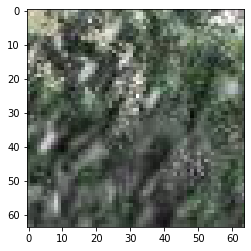

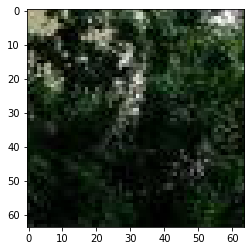

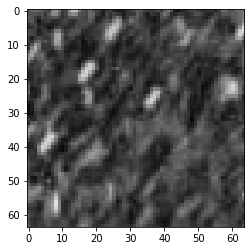

In [38]:
# Visualise Input
print("Original Input")
plt.figure()
grid = utils.make_grid(croppedImgsSnow)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(croppedImgsOrig)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(croppedImgsMask)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference Results


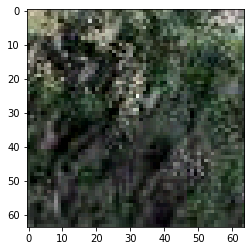

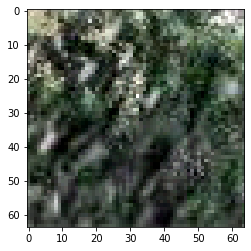

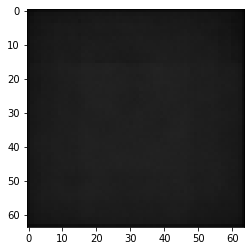

In [39]:
# Visualise Results
print("Inference Results")
plt.figure()
grid = utils.make_grid(y_hat)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(y_dash)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(z_hat)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))